# Regressão Linear com PyTorch

## Objetivos

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se:
- a função de perda MSE do PyTorch,
- treinamento dos parâmetros via gradiente descendente usando o otimizador.
- A rede é criada com uma camada nn.Linear()

## Importação dos pacotes

In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

torch.manual_seed(1234)

## Leitura dos dados

In [2]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1].astype(np.float32)
y_train = data[:,1:2].astype(np.float32)

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float32
y_train.shape: (50, 1) float32
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [3]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()


In [4]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [5]:
x_train_bias = torch.FloatTensor(x_train_bias)
y_train      = torch.FloatTensor(y_train)

## Criação do modelo da rede

In [6]:
model = torch.nn.Linear(2, 1, bias=False)

### Verificando a inicialização dos parâmetros

In [7]:
model.weight.data = torch.zeros(1,2)
torch.nn.init.uniform(model.weight.data, -0.1, 0.1)
model.weight.data

/var/folders/kc/1xwjc0hs5d3fh5nswnpvwlmm0000gn/T/ipykernel_20049/1486225639.py:2: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  torch.nn.init.uniform(model.weight.data, -0.1, 0.1)


tensor([[-0.0480, -0.0267]])

### Testando o predict da rede

In [8]:
model(Variable(torch.ones((5,2))))

tensor([[-0.0747],
        [-0.0747],
        [-0.0747],
        [-0.0747],
        [-0.0747]], grad_fn=<MmBackward0>)

## Treinamento

### Definindo função de perda e otimizador

In [9]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)

### Laço de treinamento

In [10]:
num_epochs = 200
best_epoch_weight = None
best_epoch_number = 0
best_epoch_loss = criterion(model(Variable(x_train_bias)), Variable(y_train))
w0_list = []
w1_list = []
for epoch in range(num_epochs):
    inputs = Variable(x_train_bias)
    target = Variable(y_train)

    # forward - predict
    out = model(inputs)

    w0_list.append(model.weight.data[0][0].item())
    w1_list.append(model.weight.data[0][1].item())

    #loss cálculo da função de perda
    loss = criterion(out, target)

    # backward e otimizador
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (loss < best_epoch_loss):
        best_epoch_loss = loss
        best_epoch_weight = model.state_dict()
        best_epoch_number = epoch + 1

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.data))

Epoch[20/200], loss: 0.022983
Epoch[40/200], loss: 0.021432
Epoch[60/200], loss: 0.021207
Epoch[80/200], loss: 0.021175
Epoch[100/200], loss: 0.021170
Epoch[120/200], loss: 0.021170
Epoch[140/200], loss: 0.021169
Epoch[160/200], loss: 0.021169
Epoch[180/200], loss: 0.021169
Epoch[200/200], loss: 0.021169


In [11]:
print(best_epoch_number)
print(best_epoch_loss)
print(best_epoch_weight)


177
tensor(0.0212, grad_fn=<MseLossBackward0>)
OrderedDict([('weight', tensor([[0.2614, 0.6864]]))])


## Avaliação

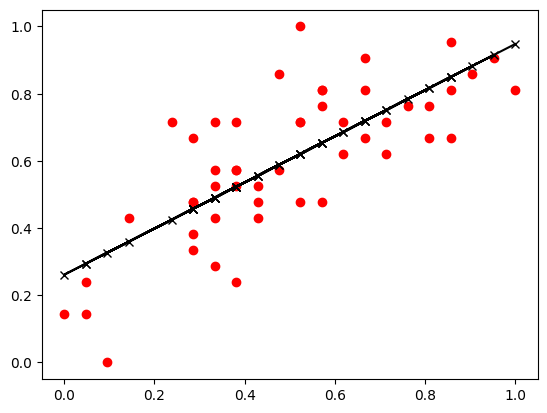

In [12]:
y_pred = model(Variable(x_train_bias))
plt.plot(x_train, y_train.numpy(), 'ro', label='Original data')
plt.plot(x_train, y_pred.data.numpy(), 'kx-', label='Fitting Line')
plt.show()

# Exercícios

- 1) Calcule o valor da função de custo (MSE) depois da rede treinada, utilizando a
   função `criterion` utilizada no laço de treinamento.

In [14]:
y_pred = model(Variable(x_train_bias))

loss = criterion(y_pred, Variable(y_train))

print('Valor do MSE após o treinamento:', loss.data.item())

Valor do MSE após o treinamento: 0.021169424057006836


<details>
<summary>Mostrar Resultado</summary>

```python
y_pred = model(Variable(x_train_bias))
loss = criterion(y_pred, Variable(y_train))
print(loss)
```

</details>

- 2) Faça igual o exercício do notebook anterior, de plotar um gráfico scatterplot para
   mostrar a evolução dos parâmetros durante o treinamento pelo gradiente descendente.

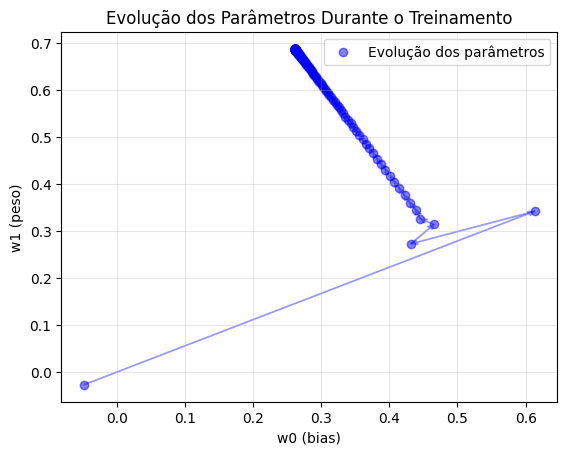

In [17]:
import matplotlib.pyplot as plt

plt.scatter(w0_list, w1_list, c='blue', alpha=0.5, label='Evolução dos parâmetros')
w0_old, w1_old = None, None
for (w0, w1) in zip(w0_list, w1_list):
    if w0_old is not None:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                 head_length=0.01, head_width=0.01,
                 shape='full', length_includes_head=True,
                 fc='blue', ec='blue', alpha=0.3)
    w0_old, w1_old = w0, w1

plt.xlabel('w0 (bias)')
plt.ylabel('w1 (peso)')
plt.title('Evolução dos Parâmetros Durante o Treinamento')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

<details>
<summary>Mostrar Resultado</summary>

```python
plt.scatter(w0_list,w1_list)
w0_old = None
for (w0,w1) in zip(w0_list,w1_list):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1
```

</details>

# Aprendizados